In [8]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

url1 = f"https://raw.githubusercontent.com/lsowa/flows/master/utils.py"
url2 = f"https://raw.githubusercontent.com/lsowa/flows/master/rnvp.png"
url2 = f"https://raw.githubusercontent.com/lsowa/flows/master/planar_flow.png"
!wget --no-cache --backups=1 {url1} {url2} {url3}

from utils import *

--2022-06-17 15:49:25--  https://raw.githubusercontent.com/lsowa/flows/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703 (4,6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4,59K  --.-KB/s    in 0,001s  

2022-06-17 15:49:25 (3,19 MB/s) - ‘utils.py’ saved [4703/4703]

--2022-06-17 15:49:25--  https://raw.githubusercontent.com/lsowa/flows/master/rnvp.png
Reusing existing connection to [raw.githubusercontent.com]:443.
HTTP request sent, awaiting response... 200 OK
Length: 17494 (17K) [image/png]
Saving to: ‘rnvp.png’

rnvp.png            100%[===================>]  17,08K  --.-KB/s    in 0,002s  

2022-06-17 15:49:25 (9,74 MB/s) - ‘rnvp.png’ saved [17494/17494]

FINISHED --2022-06-17 15

# Normalizing Flows
In this example we will first have a look at the workflow of a (very) simple normalizing planar flow model. 
Afterwards we will use the FrEIa framework to easily initialize a more complex normalizing coupling flow model.

In both cases we train a model to transform an input density (left) to a target density (right).

Text(0.5, 1.0, 'Target density')

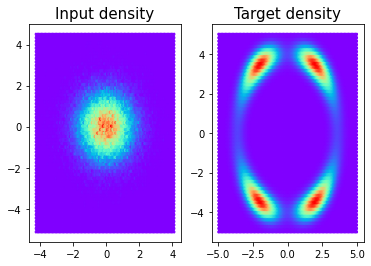

In [9]:
fig, ax = plt.subplots(1, 2)
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
z = pz.sample((int(1e5), ))
z = z.detach().numpy()
ax[0].hexbin(z[:,0], z[:,1], cmap='rainbow')
ax[0].set_title('Input density', fontsize=15)
x = np.linspace(-5, 5, 2000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
ax[1].hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
ax[1].set_title('Target density', fontsize=15)

### Simple planar flow
Note: PlanarFlows are only bijective under certain conditions, nevetheless we use them here to illustrate the workflow of a simple normalizing flow model.

<img src="planar_flow.png" width=200 height=40 /> 

In [10]:
# create a class for planar flows
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # setup learnable pytorch parameters
        self.b = nn.Parameter(torch.Tensor(1, dim))
        self.w = nn.Parameter(torch.Tensor(dim, dim))
        self.u = nn.Parameter(torch.Tensor(1, dim))
        self.init_parameters()
    
    # flow function
    def __call__(self, z):
        linear = F.linear(z, self.w, self.b)
        return z + self.u * torch.tanh(linear)

    # compute log of the Jacobian's determinant
    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.w, self.b)
        psi = F.linear(1 - torch.tanh(f_z) ** 2, self.w)
        det_grad = 1 + torch.mm(psi, self.u.t())
        return torch.log(det_grad.abs() + 1e-9)

    # initialize pytorch parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

In [11]:
# Main Model to wrap flows

class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_flows):
        super().__init__()
        # stack PlanarFlow n_flows-th times
        flows = [ PlanarFlow(dim) for i in range(n_flows) ]
        self.flows = nn.ModuleList(flows)

    # generator function g(z)=y
    def forward(self, z):
        self.log_det = []
        for b in range(len(self.flows)):
            self.log_det.append(self.flows[b].log_abs_det_jacobian(z))
            z = self.flows[b](z)
        return z, self.log_det 

Train and evaluate the model..

Iter. 0 Loss: 18.07651
Iter. 180 Loss: 16.59141
Iter. 360 Loss: 12.20437
Iter. 540 Loss: 7.78603
Iter. 720 Loss: 5.20990
Iter. 900 Loss: 3.69525
Iter. 1080 Loss: 3.55801
Iter. 1260 Loss: 3.35423
Iter. 1440 Loss: 2.82344
Iter. 1620 Loss: 2.67986
Iter. 1800 Loss: 2.97538


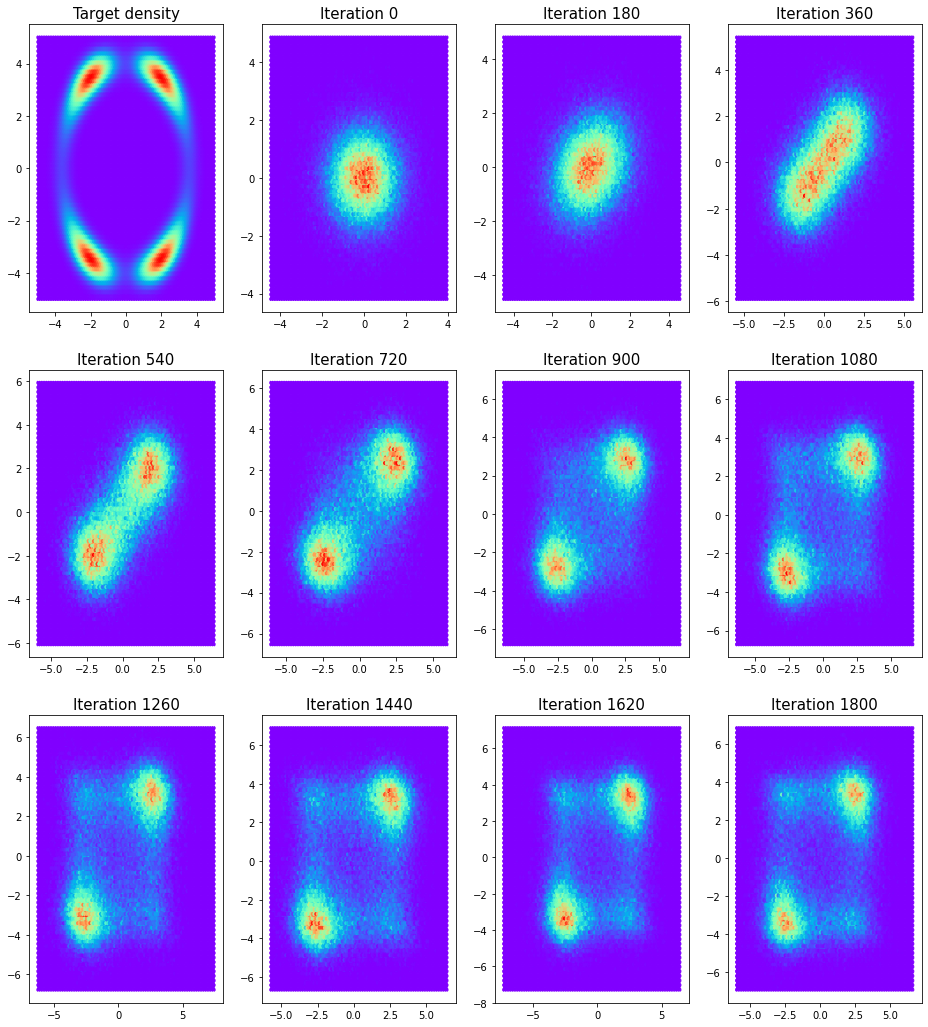

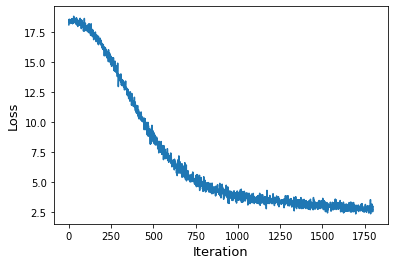

In [12]:
# Initialize and train the NormalizingFlow model
flow = NormalizingFlow(dim=2, n_flows=2)
train(model=flow,
      iterations=1801, 
      lr=0.001,
      #device=torch.device('cuda:0') # default: 'cpu'
      )

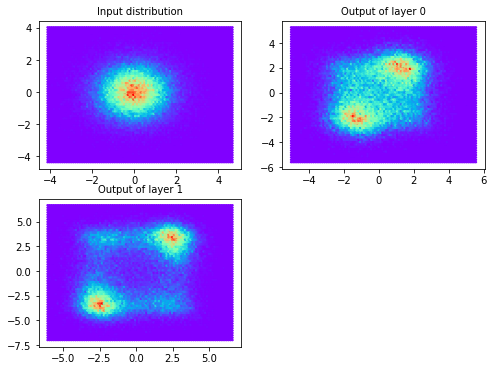

In [13]:
# Evaluate the model and plot its output after each layer
model_layerwise(flow, name='simplemodel')

# More complex flow using the FrEIA framework

In [14]:
# use https://github.com/VLL-HD/FrEIA from Visual Learning Lab Heidelberg
!pip install git+https://github.com/VLL-HD/FrEIA.git #uncomment to install FrEIa
import FrEIA.framework as Ff
import FrEIA.modules as Fm

  Cloning https://github.com/VLL-HD/FrEIA.git to /tmp/pip-req-build-lgi22ivy
  Running command git clone --filter=blob:none --quiet https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-lgi22ivy
  Resolved https://github.com/VLL-HD/FrEIA.git to commit 1779d1fba1e21000fda1927b59eeac0a6fcaa284
  Preparing metadata (setup.py) ... done


Now one can try out different coupling flows like RNVP coupling. 

<img src="rnvp.png" width=420 height=60 /> 

The *mlp_constructor* function creates networks for the mappings *s* and *t*.

In [15]:
def mlp_constructor(input_dim=2, out_dim=2, hidden_nodes=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, out_dim)
        )
    return model

In [16]:
# Initialize a FrEIA model and append some modules to it
# have a look at the documentation of the layers:
#   https://vll-hd.github.io/FrEIA/_build/html/FrEIA.modules.html
inn = Ff.SequenceINN(2)
for k in range(8):
    inn.append(Fm.RNVPCouplingBlock, subnet_constructor=mlp_constructor, clamp=0.01) 
    #inn.append(Fm.NICECouplingBlock, subnet_constructor=mlp_constructor)
    #inn.append(Fm.PermuteRandom)


Iter. 0 Loss: 18.49516
Iter. 50 Loss: 1.36388
Iter. 100 Loss: 1.26397
Iter. 150 Loss: 1.21825
Iter. 200 Loss: 1.07001
Iter. 250 Loss: 1.08239
Iter. 300 Loss: 0.99501
Iter. 350 Loss: 0.84868
Iter. 400 Loss: 0.92638
Iter. 450 Loss: 1.04951
Iter. 500 Loss: 0.87306


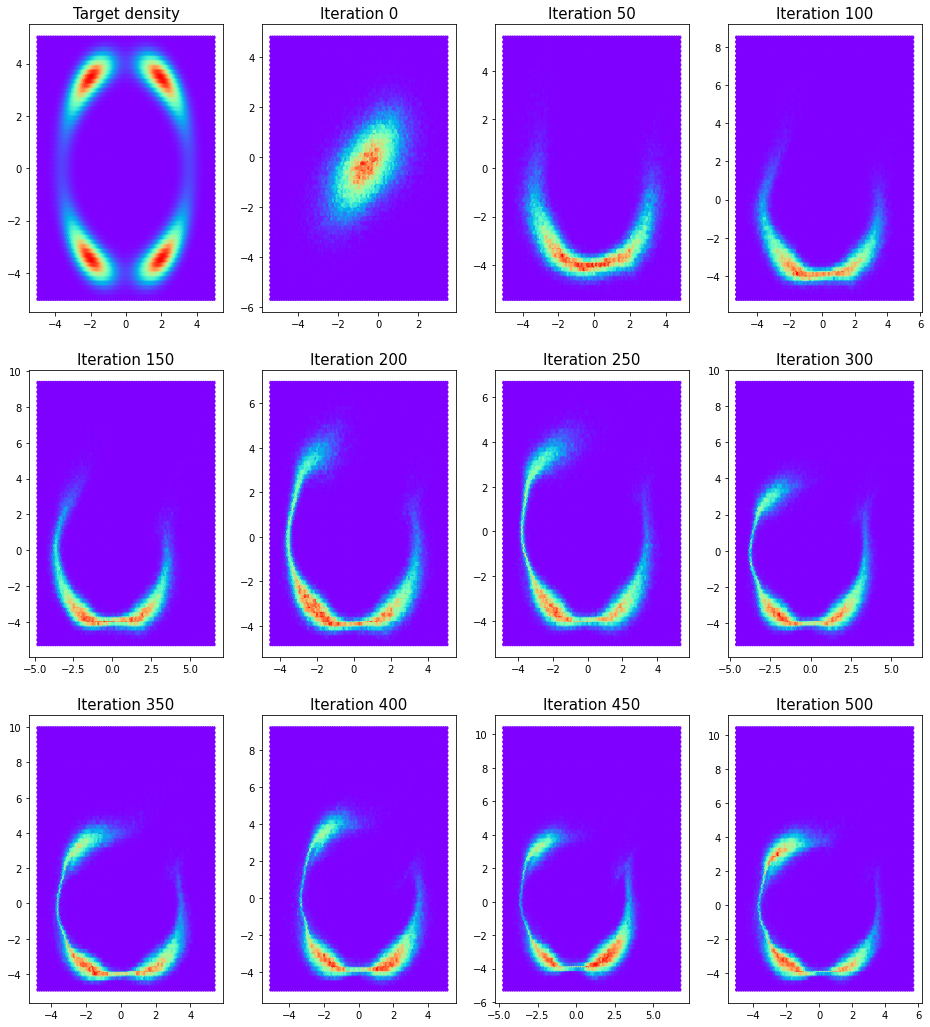

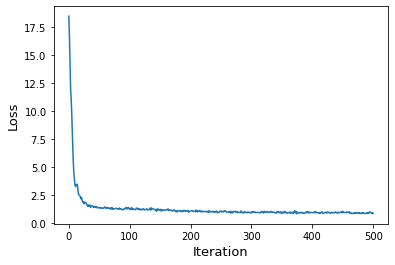

In [17]:
# train FrEIA model
train(model=inn,
      iterations=501, 
      lr=0.001,
      scheduler=0.999,
      #device=torch.device('cuda:0') # default: 'cpu'
      )

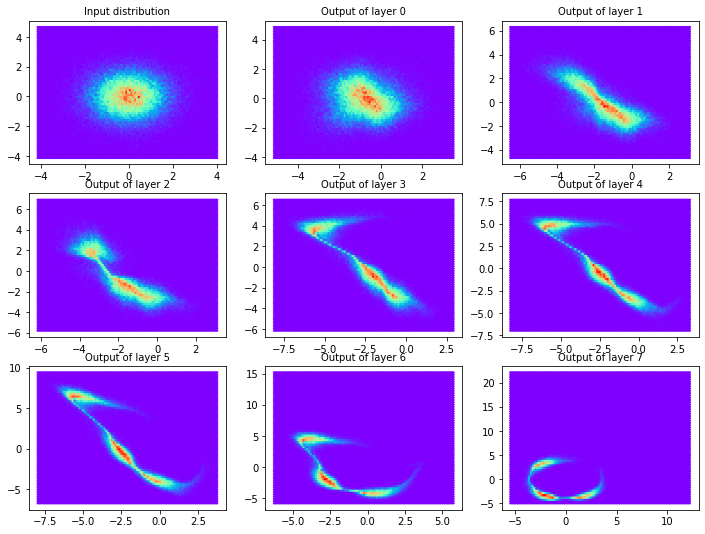

In [18]:
# Evaluate the model and plot its output after each layer
model_layerwise(inn, 
                name='freia')

Finally test the model for its bijectivity..

In [19]:
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
z = pz.sample((int(10), ))

inn.cpu()
y, _ = inn(z)
z_rev, _ = inn(y, rev=True)

# inverting from the outputs should give the original inputs again
print('Model is bijective: \n', bool(torch.max(torch.abs(z_rev - z)) < 1e-5))

Model is bijective: 
 True
